# 1

Open lab notebook, copy code from Multiple input / output channels section

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

We need to add another line to `X`, containing the matrix that represents the third input channel.

We also need to add another matrix to `K` and set its values as in the exercise.

Luckily, the other `2` matrixes are already set correctly:

In [2]:
X = torch.tensor([[[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]],
               [[1.0, 2.0, 2.0], [4.0, 1.0, 6.0], [7.0, 8.0, 9.0]]
               ]])
K = torch.tensor([[[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]], [[7.0, 2.0], [3.0, 5.0]]]])
F.conv2d(X, K)

tensor([[[[ 84., 123.],
          [195., 208.]]]])

# 2

Find the LeNet section and the FashionMNIST section and start copying code:

We need to change `2` things:
- for the first convolution, which was `nn.Conv2d(1, 6)`, we need to replace it with `nn.Conv2d(3, 6)` because the images in SVHN are RGB images
- for the first linear layer, the one after the flatten, we need to change its number of inputs
- to do this, either:
    - analyze the network to figure out the shape before the flatten
    - run the network with some random value, leading to an error saying `mat1 and mat2 can't be multiplied, where mat1 is of shape 256x**576**`. `576` is the correct number of input features for the linear layer
    - remove everything after the flatten layer, run the network with some random input and look at the output shape with `net(torch.rand(1, 3, 32, 32)).shape` 

In [3]:
net = nn.Sequential(
    # image of shape 3 x 32 x 32
    nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    # shape 6 x 32 x 32 because padding = kernel_size / 2
    nn.AvgPool2d(kernel_size=2, stride=2),
    # shape 6 x 16 x 16
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    # shape 16 x (16 - 4) x (16 - 4)
    # 16 x 12 x 12
    nn.AvgPool2d(kernel_size=2, stride=2),
    # 16 x 6 x 6
    nn.Flatten(),
    # otherwise: mat1 cannot be multiplied by mat2
    # mat1 is [256, 576]
    nn.Linear(16 * 6 * 6, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))
net

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=576, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

We need to use SVHN, so replace FashionMNIST with SVHN in `torchvision.datasets.FashionMNIST`. 
To use SVHN, we need to also:
- replace `train=True` with `split="train"`
- replace `train=False` with `split="test"`
- read more: https://pytorch.org/vision/main/generated/torchvision.datasets.SVHN.html

Make sure to use `30000` validation images and `43257` training images:

In [4]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.SVHN(
        root="../data", split="train", transform=trans, download=True)
    mnist_test = torchvision.datasets.SVHN(
        root="../data", split="test", transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [43257, 30000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

In [5]:
def evaluate_accuracy(net, data_iter, loss, device):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

In [6]:
def train_epoch(net, train_iter, loss, optimizer, device):
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

In [7]:
def train(net, train_iter, val_iter, test_iter, num_epochs, lr, device):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('Training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer, device)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter, loss, device)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')
    test_loss, test_acc = evaluate_accuracy(net, test_iter, loss, device)
    print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

In [8]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [9]:
def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1)
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [10]:
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Set learning rate to `0.5`:

In [11]:
batch_size, lr, num_epochs = 256, 0.5, 10
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu()) #2 min

Using downloaded and verified file: ../data\train_32x32.mat
Using downloaded and verified file: ../data\test_32x32.mat
Training on cuda:0
Epoch 1, Train loss 2.26, Train accuracy 17.78, Validation loss 2.25, Validation accuracy 18.97
Epoch 2, Train loss 2.24, Train accuracy 18.38, Validation loss 2.24, Validation accuracy 18.97
Epoch 3, Train loss 2.24, Train accuracy 18.77, Validation loss 2.24, Validation accuracy 18.97
Epoch 4, Train loss 2.24, Train accuracy 18.88, Validation loss 2.24, Validation accuracy 18.97
Epoch 5, Train loss 2.24, Train accuracy 18.88, Validation loss 2.24, Validation accuracy 18.97
Epoch 6, Train loss 2.24, Train accuracy 18.86, Validation loss 2.24, Validation accuracy 18.97
Epoch 7, Train loss 2.24, Train accuracy 18.87, Validation loss 2.24, Validation accuracy 18.97
Epoch 8, Train loss 2.24, Train accuracy 18.88, Validation loss 2.24, Validation accuracy 18.97
Epoch 9, Train loss 2.24, Train accuracy 18.88, Validation loss 2.24, Validation accuracy 18.9

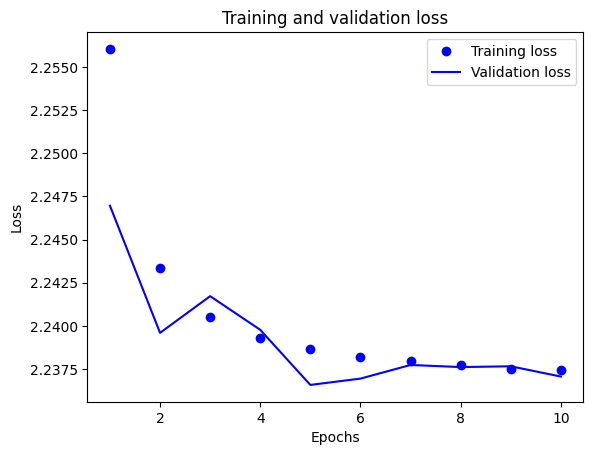

In [12]:
plot_loss(train_loss_all, val_loss_all)

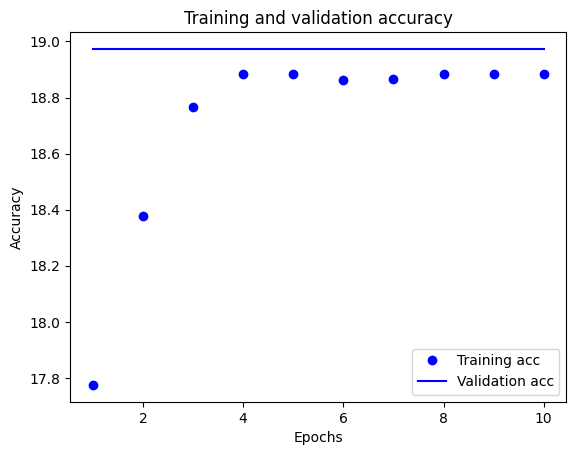

In [13]:
plot_accuracy(train_acc_all, val_acc_all)